WEB SCRAPING TO EXTRACT DATA FROM WIKI PAGE

In [ ]:
#extract data from wiki page
from bs4 import BeautifulSoup
import requests
import csv
import string

# Function to scrape attributes from an individual aesthetic page
def scrape_aesthetic(aesthetic_url):
    try:
        response = requests.get(aesthetic_url)
        response.raise_for_status()  # Raise an exception for HTTP errors
        soup = BeautifulSoup(response.content, 'html.parser')

        aesthetic_name = soup.find('h1', class_='page-header__title').text.strip()

        decade_element = soup.find('h3', text='Decade of origin')
        decade = decade_element.find_next_sibling('div').text.strip() if decade_element else 'null'

        motifs_element = soup.find('h3', text='Key motifs')
        motifs = motifs_element.find_next_sibling('div').text.strip() if motifs_element else 'null'

        colours_element = soup.find('h3', text='Key colours')
        colours = colours_element.find_next_sibling('div').text.strip() if colours_element else 'null'

        related_aesthetics_element = soup.find('h3', text='Related aesthetics')
        related_aesthetics = related_aesthetics_element.find_next_sibling('div').text.strip() if related_aesthetics_element else 'null'

        related_media_element = soup.find('h3', text='Related media')
        related_media = related_media_element.find_next_sibling('div').text.strip() if related_media_element else 'null'

        return [aesthetic_name, decade, motifs, colours, related_aesthetics, related_media]

    except requests.exceptions.RequestException as e:
        print(f"Error fetching {aesthetic_url}: {e}")
        return None

# Main script to scrape aesthetics Y-Z
base_url = 'https://aesthetics.fandom.com'
start_url = base_url + '/wiki/Category:Fashion?from='

data = []

try:
    # Generate URLs for each letter from Y-Z
    for char in string.ascii_uppercase[string.ascii_uppercase.index('Y'):]:
        next_page = start_url + char

        while next_page:
            response = requests.get(next_page)
            response.raise_for_status()  # Raise an exception for HTTP errors
            soup = BeautifulSoup(response.content, 'html.parser')

            aesthetics = soup.find_all('a', class_='category-page__member-link')

            for aesthetic in aesthetics:
                aesthetic_url = base_url + aesthetic['href']
                data.append(scrape_aesthetic(aesthetic_url))

            # Check for next page link
            next_page_link = soup.find('a', class_='category-page__pagination-next')
            next_page = base_url + next_page_link['href'] if next_page_link else None

except requests.exceptions.RequestException as e:
    print(f"Error with request: {e}")

# Write data to CSV
headers = ['Aesthetic', 'Decade of origin', 'Key motifs', 'Key colours', 'Related aesthetics', 'Related media']

with open('aesthetics_data_Y-Z.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows([item for item in data if item is not None])


<ipython-input-5-f953bf040c79>:15: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  decade_element = soup.find('h3', text='Decade of origin')
<ipython-input-5-f953bf040c79>:18: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  motifs_element = soup.find('h3', text='Key motifs')
<ipython-input-5-f953bf040c79>:21: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  colours_element = soup.find('h3', text='Key colours')
<ipython-input-5-f953bf040c79>:24: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  related_aesthetics_element = soup.find('h3', text='Related aesthetics')
<ipython-input-5-f953bf040c79>:27: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  related_media_element = soup.find('h3', text='Related media')


CLUSTER THE AESTHETICS (NOT TO BE INCLUDED IN WEBSITE)

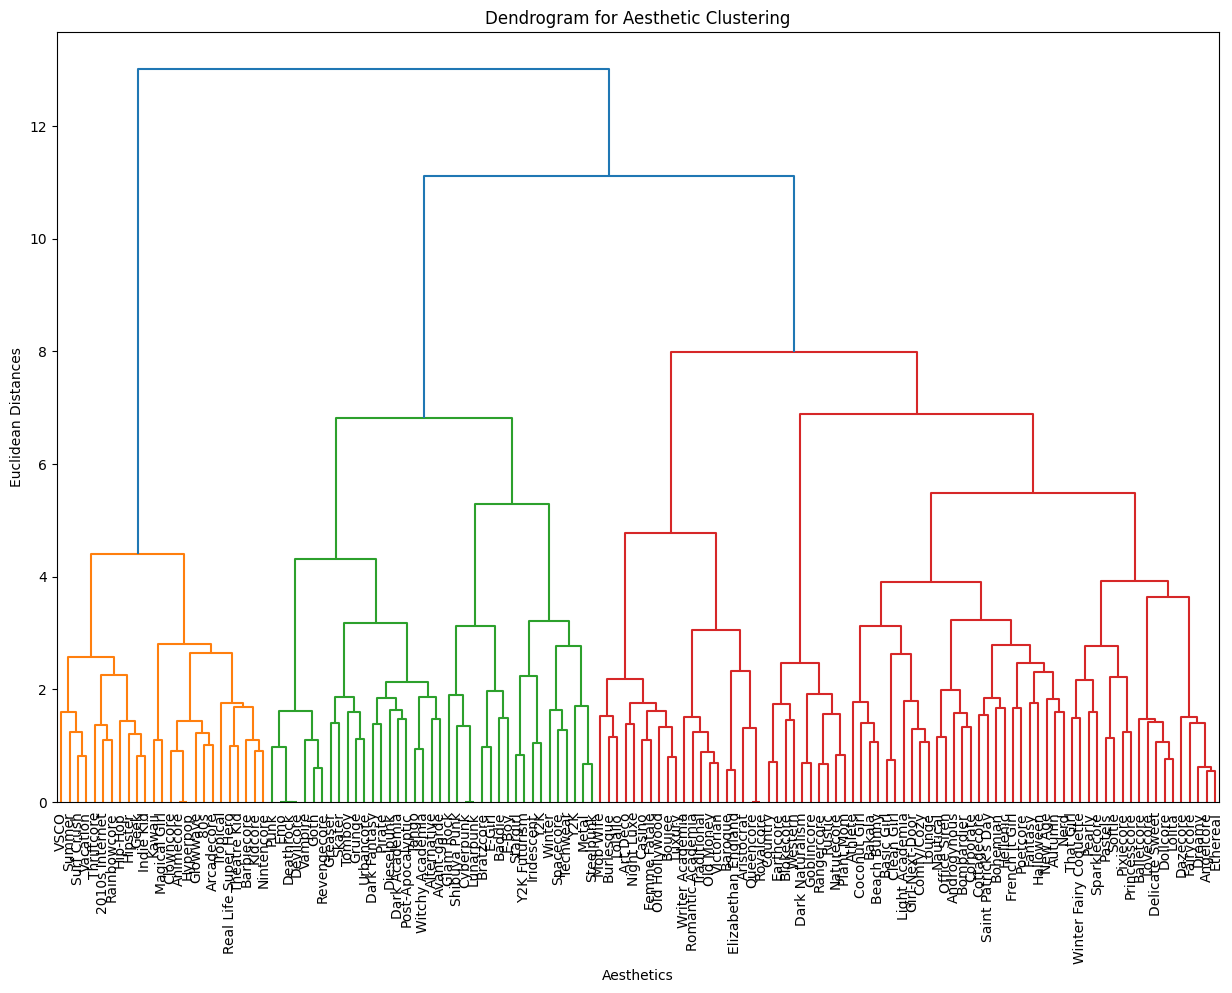

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


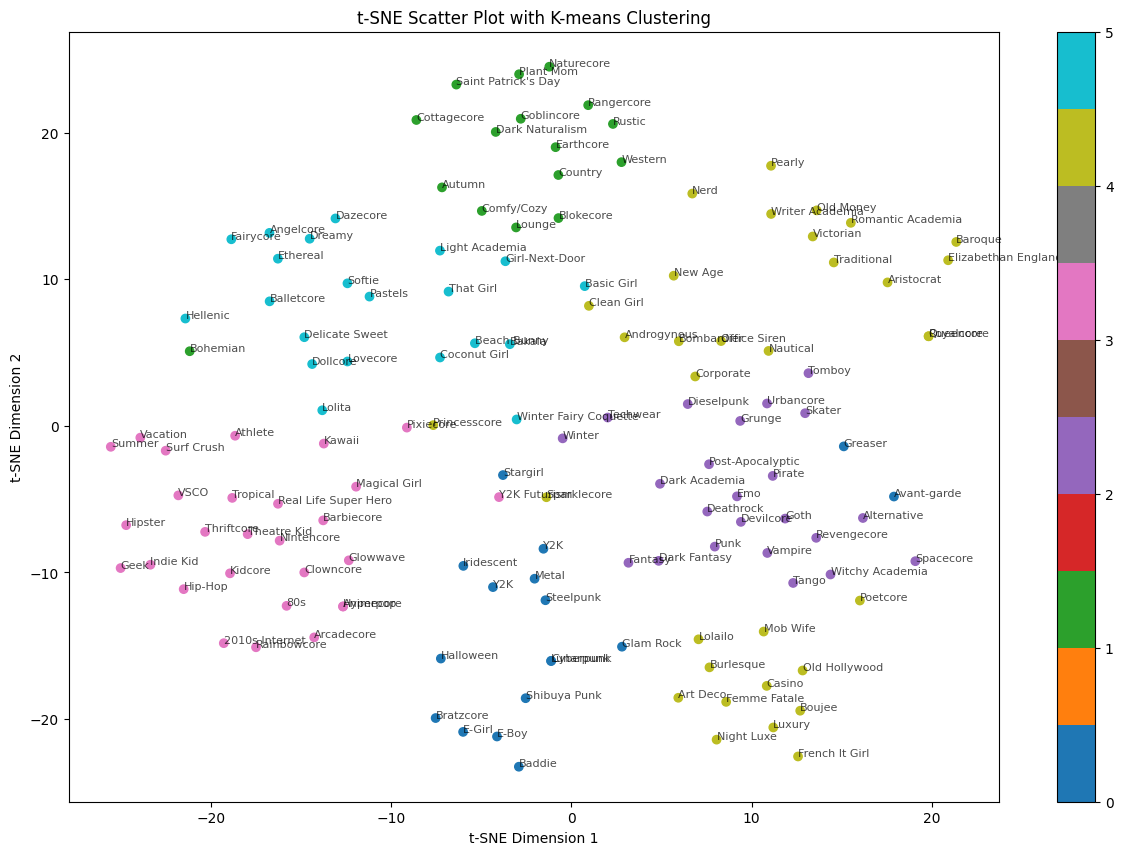

In [2]:
#cluster aesthetics
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


# Load the Excel file
file_path = 'aesthetics_file.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Combine key motifs and key colours into one column for analysis
df['combined'] = df['Key motifs'] + ' ' + df['Key colours']

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['combined'])

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Generate the linkage matrix
linkage_matrix = sch.linkage(cosine_sim, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram = sch.dendrogram(linkage_matrix, labels=df['Aesthetic'].values, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrogram for Aesthetic Clustering')
plt.xlabel('Aesthetics')
plt.ylabel('Euclidean Distances')
plt.show()

# Dimensionality reduction with PCA before clustering
pca = PCA(n_components=50)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Perform K-means clustering with optimized number of clusters
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(pca_result)
labels = kmeans.labels_

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=1000)
tsne_results = tsne.fit_transform(pca_result)

# Create a scatter plot
plt.figure(figsize=(15, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10')

# Annotate points with aesthetic names
for i, label in enumerate(df['Aesthetic']):
    plt.annotate(label, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=8, alpha=0.7)

plt.colorbar(scatter)
plt.title('t-SNE Scatter Plot with K-means Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


CLUSTER AESTHETICS, CLUSTER CLOTHING ITEMS
TAKE USER INPUT (AESTHETIC) AND OUTPUT CLOTHING ITEMS

In [54]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# Load the aesthetics dataset
aesthetic_file_path = 'aesthetics_file.xlsx'
aesthetic_df = pd.read_excel(aesthetic_file_path, sheet_name='Sheet1')

# Combine key motifs and key colours into one column for analysis
aesthetic_df['combined'] = aesthetic_df['Key motifs'] + ' ' + aesthetic_df['Key colours']

# Load the clothing dataset
clothing_file_path = 'cleaned_clothing_file.csv'
clothing_df = pd.read_csv(clothing_file_path)

# Ensure proper formatting of the 'features' column
def preprocess_text(text):
    # Remove unwanted words
    words_to_remove = ['dress', 'top', 'trousers', 'anarkali', 'shirt', 'tee', 'pant']
    for word in words_to_remove:
        text = text.replace(word, '')
    text = ' '.join(text.split())  # Remove extra spaces created by replacements
    return text

# Apply preprocessing
clothing_df['features'] = clothing_df['features'].apply(preprocess_text)

# Initialize Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for aesthetics and clothing items
aesthetic_embeddings = model.encode(aesthetic_df['combined'].tolist())
clothing_embeddings = model.encode(clothing_df['features'].tolist())

# Dimensionality reduction with t-SNE for visualization
'''def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=1000)
    tsne_results = tsne.fit_transform(embeddings)

    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()'''

# Perform K-means clustering for aesthetics
aesthetic_kmeans = KMeans(n_clusters=6, random_state=42)
aesthetic_kmeans.fit(aesthetic_embeddings)
aesthetic_labels = aesthetic_kmeans.labels_
aesthetic_df['cluster'] = aesthetic_labels

# Plot t-SNE results for aesthetics
#plot_tsne(aesthetic_embeddings, aesthetic_labels, 't-SNE Scatter Plot for Aesthetics')

# Perform K-means clustering for clothing items
clothing_kmeans = KMeans(n_clusters=6, random_state=42)
clothing_kmeans.fit(clothing_embeddings)
clothing_labels = clothing_kmeans.labels_
clothing_df['cluster'] = clothing_labels

# Plot t-SNE results for clothing items
#plot_tsne(clothing_embeddings, clothing_labels, 't-SNE Scatter Plot for Clothing Items')

# Optional: Calculate distances and find closest clothing items for a given aesthetic
def get_items_with_min_distance(aesthetic):
    if aesthetic not in aesthetic_df['Aesthetic'].values:
        print(f"Aesthetic '{aesthetic}' not found in the dataset.")
        return pd.DataFrame(columns=['image', 'description'])

    # Find the index of the input aesthetic
    aesthetic_index = aesthetic_df.loc[aesthetic_df['Aesthetic'] == aesthetic].index[0]

    # Get the distances of all clothing items to the input aesthetic
    clothing_distances = euclidean_distances(clothing_embeddings, aesthetic_embeddings[aesthetic_index].reshape(1, -1))

    # Get the clothing items with the minimum distance to the input aesthetic
    min_distance_indices = clothing_distances.flatten().argsort()[:10]  # Adjust number as needed
    items_with_min_distance = clothing_df.iloc[min_distance_indices]

    return items_with_min_distance

# Get user input for the aesthetic
user_aesthetic = input("Enter an aesthetic: ")

# Get items with minimum distance to the input aesthetic
items_with_min_distance = get_items_with_min_distance(user_aesthetic)

# Display the items with minimum distance
print(items_with_min_distance[['image', 'description']])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Enter an aesthetic: Barbiecore
                                                image  \
83  /content/extracted_files/women fashion/white d...   
84  /content/extracted_files/women fashion/long, f...   
61  /content/extracted_files/women fashion/bright ...   
48  /content/extracted_files/women fashion/solid d...   
40  /content/extracted_files/women fashion/black d...   
10  /content/extracted_files/women fashion/blue dr...   
32  /content/extracted_files/women fashion/bright ...   
2   /content/extracted_files/women fashion/off-the...   
44  /content/extracted_files/women fashion/anarkal...   
17  /content/extracted_files/women fashion/floral ...   

                                     description  
83                white colorful floral patterns  
84             elegant long flowing pink sparkly  
61             ethnic bright red kurta intricate  
48         solid dark blue floral pattern bottom  
40                  elegant black lace detailing  
10                    summer blue f